## Searching for bouts for a day of ephys recording
- Microhpone already extracted and left in derived_data as a wav file in sglx_pipe-dev-sort-bouts-s_b1253_21-20210614


In [24]:
%matplotlib inline
import os
import glob
import socket
import logging
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from ceciestunepipe.util import sglxutil as sglu

from matplotlib import pyplot as plt

from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.info('Running on {}'.format(socket.gethostname()))

2021-09-14 15:48:28,920 root         INFO     Running on pakhi
2021-09-14 15:48:28,920 root         INFO     Running on pakhi


In [25]:
from ceciestunepipe.file import bcistructure as et

### Get the file locations for a session (day) of recordings

In [26]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-07-17',
           'sort': 2}


exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='sglx')

raw_folder = exp_struct['folders']['sglx']

In [27]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2021-09-14 15:48:31,153 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-17', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-17/sglx', 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-07-17', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-17/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-07-17', 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-07-17'}, 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-07-17/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-17/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-17/sglx/rig.json', 'kwd': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-07-17/stream.kwd', 'kwik': '/scratch/earneodo/s_b1253_21/sgl

['0738_g0', '0957_g0', '1206_g0', '1648_g0']

In [28]:
### pick an epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [29]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/0738_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-17/0738_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-17/sglx/0738_g0',
 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-07-17/0738_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-17/sglx/0738_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0',
 'tmp': '/scratch/earneodo/tmp/0738_g0',
 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-07-17/0738_g0',
 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-07-17/0738_g0'}

In [43]:
import librosa

#### search parameters
Spectrograms are computed using librosa

Additional parameters are for bout search criteria and functions to read the data

In [30]:
# function for getting one channel out of a wave file
def read_wav_chan(wav_path: str, chan_id: int=0) -> tuple:
    s_f, x = wavfile.read(wav_path, mmap=True)
    if x.ndim==1:
        if chan_id > 0:
            raise ValueError('Wave file has only one channel, asking for channel {}'.format(chan_id))
        x = x.reshape(-1, 1)
    
    return s_f, x[:, chan_id]

def sess_file_id(f_path):
    n = int(os.path.split(f_path)[1].split('-')[-1].split('.wav')[0])
    return n

hparams = {
    # spectrogram
    'num_freq':1024, #1024# how many channels to use in a spectrogram #
    'preemphasis':0.97, 
    'frame_shift_ms':5, # step size for fft
    'frame_length_ms':10, #128 # frame length for fft FRAME SAMPLES < NUM_FREQ!!!
    'min_level_db':-55, # minimum threshold db for computing spe 
    'ref_level_db':110, # reference db for computing spec
    'sample_rate':None, # sample rate of your data
    
    # spectrograms
    'mel_filter': False, # should a mel filter be used?
    'num_mels':1024, # how many channels to use in the mel-spectrogram
    'fmin': 500, # low frequency cutoff for mel filter
    'fmax': 12000, # high frequency cutoff for mel filter
    
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':20,
    'power':1.5,

    # Added for the searching
    'read_wav_fun': read_wav_chan, # function for loading the wav_like_stream (has to returns fs, ndarray)
    'file_order_fun': sess_file_id, # function for extracting the file id within the session
    'min_segment': 30, # Minimum length of supra_threshold to consider a 'syllable' (ms)
    'min_silence': 2000, # Minmum distance between groups of syllables to consider separate bouts (ms)
    'min_bout': 5000, # min bout duration (ms)
    'peak_thresh_rms': 0.55, # threshold (rms) for peak acceptance,
    'thresh_rms': 0.25, # threshold for detection of syllables
    'mean_syl_rms_thresh': 0.3, #threshold for acceptance of mean rms across the syllable (relative to rms of the file)
    'max_bout': 120000, #exclude bouts too long
    'l_p_r_thresh': 100, # threshold for n of len_ms/peaks (typycally about 2-3 syllable spans
    
    'waveform_edges': 1000, #get number of ms before and after the edges of the bout for the waveform sample
    
    'bout_auto_file': 'bout_auto.pickle', # extension for saving the auto found files
    'bout_curated_file': 'bout_checked.pickle', #extension for manually curated files (coming soon)
    }

#### Get one wave file

In [31]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/0738_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-17/0738_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-17/sglx/0738_g0',
 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-07-17/0738_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-17/sglx/0738_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0',
 'tmp': '/scratch/earneodo/tmp/0738_g0',
 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-07-17/0738_g0',
 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-07-17/0738_g0'}

In [32]:
one_wav_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')

s_f, x = read_wav_chan(one_wav_path)

hparams['sample_rate'] = s_f

In [33]:
x.shape

(207854592,)

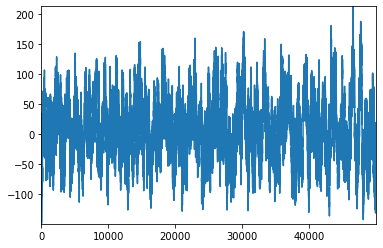

In [34]:
plt.plot(x[:50000])

### try the function to search for bouts in the file

In [35]:
from ceciestunepipe.util.sound import boutsearch as bs
from joblib import Parallel, delayed
import pickle

### get all bouts of the day

In [36]:
reload(bs)

<module 'ceciestunepipe.util.sound.boutsearch' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/sound/boutsearch.py'>

In [37]:
exp_struct['folders']['sglx']

'/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-17/sglx/0738_g0'

In [38]:
derived_folder = os.path.split(exp_struct['folders']['derived'])[0]

sess_files = et.get_sgl_files_epochs(derived_folder, file_filter='*mic.wav')
sess_files

['/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/wav_mic.wav',
 '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/wav_mic.wav',
 '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1206_g0/wav_mic.wav',
 '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1648_g0/wav_mic.wav']

In [39]:
sess_files

['/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/wav_mic.wav',
 '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/wav_mic.wav',
 '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1206_g0/wav_mic.wav',
 '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1648_g0/wav_mic.wav']

In [40]:
### Force run and save for a single epoch
one_wav_bout_pd = bs.get_bouts_in_long_file(sess_files[1], hparams)

i_folder = os.path.split(sess_files[1])[0]
epoch_bout_pd = one_wav_bout_pd[0]

epoch_bouts_path = os.path.join(i_folder, hparams['bout_auto_file'])
hparams_pickle_path = os.path.join(i_folder, 'bout_search_params.pickle')

with open(hparams_pickle_path, 'wb') as fh:
    save_param = hparams.copy()
    save_param['read_wav_fun'] = save_param['read_wav_fun'].__name__
    save_param['file_order_fun'] = save_param['file_order_fun'].__name__

    pickle.dump(save_param, fh)

logger.info('saving bouts pandas to ' + epoch_bouts_path)
epoch_bout_pd.to_pickle(epoch_bouts_path)

2021-09-14 15:48:49,361 ceciestunepipe.util.sound.boutsearch INFO     Getting bouts for long file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/wav_mic.wav
2021-09-14 15:48:49,361 ceciestunepipe.util.sound.boutsearch INFO     Getting bouts for long file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/wav_mic.wav


tu vieja file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/wav_mic.wav


2021-09-14 15:48:50,607 ceciestunepipe.util.sound.boutsearch INFO     splitting file into 3 chunks
2021-09-14 15:48:50,607 ceciestunepipe.util.sound.boutsearch INFO     splitting file into 3 chunks


  0%|          | 0/3 [00:00<?, ?it/s]

2021-09-14 15:53:17,004 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/bout_auto.pickle
2021-09-14 15:53:17,004 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/bout_auto.pickle


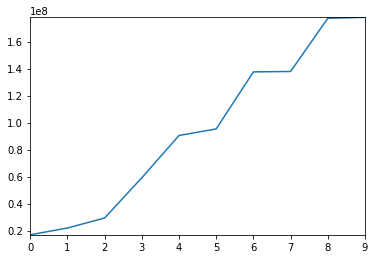

In [41]:
plt.plot(one_wav_bout_pd[0]['start_sample'].values)

In [42]:
def get_all_day_bouts(sess_par: dict, hparams:dict, n_jobs: int=28, ephys_software='sglx') -> pd.DataFrame:
    
    logger.info('Will search for bouts through all session {}, {}'.format(sess_par['bird'], sess_par['sess']))
    exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software=ephys_software)

    # get all the paths to the wav files of the epochs of the day   
    source_folder = exp_struct['folders']['derived']
    wav_path_list = et.get_sgl_files_epochs(source_folder, file_filter='*wav_mic.wav')
    wav_path_list.sort()
    logger.info('Found {} files'.format(len(wav_path_list)))
    print(wav_path_list)
    
    def get_file_bouts(i_path):
        epoch_bout_pd = bs.get_bouts_in_long_file(i_path, hparams)[0]
        
        i_folder = os.path.split(i_path)[0]
        epoch_bouts_path = os.path.join(i_folder, hparams['bout_auto_file'])
        hparams_pickle_path = os.path.join(i_folder, 'bout_search_params.pickle')

        logger.info('saving bout detect parameters dict to ' + hparams_pickle_path)
        with open(hparams_pickle_path, 'wb') as fh:
            save_param = hparams.copy()
            save_param['read_wav_fun'] = save_param['read_wav_fun'].__name__
            save_param['file_order_fun'] = save_param['file_order_fun'].__name__
            
            pickle.dump(save_param, fh)
        
        logger.info('saving bouts pandas to ' + epoch_bouts_path)
        epoch_bout_pd.to_pickle(epoch_bouts_path)

        #epoch_bout_pd = pd.DataFrame()
        return epoch_bout_pd
    
    # Go parallel through all the paths in the day, get a list of all the pandas dataframes for each file
    sess_pd_list = Parallel(n_jobs=n_jobs, verbose=100, backend=None)(delayed(get_file_bouts)(i) for i in wav_path_list)
    #sess_pd_list = [get_file_bouts(i) for i in wav_path_list]
    
    #concatenate the file and return it, eventually write to a pickle
    sess_bout_pd = pd.concat(sess_pd_list)
    return sess_bout_pd

# for large files set n_jobs to 1
sess_bout_pd = get_all_day_bouts(sess_par, hparams, n_jobs=6)

2021-09-14 15:53:17,982 root         INFO     Will search for bouts through all session s_b1253_21, 2021-07-17
2021-09-14 15:53:17,982 root         INFO     Will search for bouts through all session s_b1253_21, 2021-07-17
2021-09-14 15:53:19,892 root         INFO     Found 4 files
2021-09-14 15:53:19,892 root         INFO     Found 4 files


['/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/wav_mic.wav', '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/wav_mic.wav', '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1206_g0/wav_mic.wav', '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1648_g0/wav_mic.wav']
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done   2 out of   4 | elapsed: 14.6min remaining: 14.6min
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed: 18.6min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed: 18.6min finished


In [64]:
hparams

{'num_freq': 1024,
 'preemphasis': 0.97,
 'frame_shift_ms': 5,
 'frame_length_ms': 10,
 'min_level_db': -55,
 'ref_level_db': 110,
 'sample_rate': 25000,
 'mel_filter': False,
 'num_mels': 1024,
 'fmin': 500,
 'fmax': 12000,
 'max_iters': 200,
 'griffin_lim_iters': 20,
 'power': 1.5,
 'read_wav_fun': <function __main__.read_wav_chan(wav_path: str, chan_id: int = 0) -> tuple>,
 'file_order_fun': <function __main__.sess_file_id(f_path)>,
 'min_segment': 30,
 'min_silence': 2000,
 'min_bout': 5000,
 'peak_thresh_rms': 0.55,
 'thresh_rms': 0.25,
 'mean_syl_rms_thresh': 0.3,
 'max_bout': 120000,
 'l_p_r_thresh': 100,
 'waveform_edges': 1000,
 'bout_auto_file': 'bout_auto.pickle',
 'bout_curated_file': 'bout_checked.pickle'}

In [ ]:
sess_bout_pd.head()

In [52]:
import sys
sys.stdout.flush()

In [53]:
sess_bout_pd.shape

(98, 16)

In [1]:
sess_bout_pd

NameError: name 'sess_bout_pd' is not defined

### save the pandas for the day as a pickle

In [62]:
def save_auto_bouts(sess_bout_pd, sess_par, hparams):
    exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='sglx')
    sess_bouts_dir = os.path.join(exp_struct['folders']['derived'], 'bouts_ceciestunepipe')

    sess_bouts_path = os.path.join(sess_bouts_dir, hparams['bout_auto_file'])
    hparams_pickle_path = os.path.join(sess_bouts_dir, 'bout_search_params.pickle')

    os.makedirs(sess_bouts_dir, exist_ok=True)
    logger.info('saving bouts pandas to ' + sess_bouts_path)
    sess_bout_pd.to_pickle(sess_bouts_path)

    logger.info('saving bout detect parameters dict to ' + hparams_pickle_path)
    with open(hparams_pickle_path, 'wb') as fh:
        pickle.dump(hparams, fh)
        
save_auto_bouts(sess_bout_pd, sess_par, hparams)

2021-08-13 16:36:07,942 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/bouts_ceciestunepipe/bout_auto.pickle
2021-08-13 16:36:13,238 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/bouts_ceciestunepipe/bout_search_params.pickle


In [63]:
sess_bout_pd.head(1)

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,syl_in,n_syl,peaks_p,n_peaks,l_p_ratio,waveform
0,6340,12610,126800,252200,"[279.1424913127069, 237.28552677964962, 154.69...",32.49787,318.396805,True,/mnt/sphere/speech_bci/derived_data/s_b1253_21...,6270,"[[6340, 6385], [6560, 6605], [6695, 6740], [67...",14,"[13, 20, 35, 45, 59, 72, 85, 103, 121, 133, 14...",50,125.4,"[-1847, -1860, -1872, -1873, -1852, -1881, -19..."


### save the bouts of a pandas as wavs

In [57]:
bird_bouts_folder = os.path.abspath('/mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav')
bird_bouts_folder

'/mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav'

In [58]:
os.makedirs(bird_bouts_folder, exist_ok=True)

In [59]:
a_bout = sess_bout_pd.iloc[0]

In [60]:
a_bout['file']

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_mic.wav'

In [61]:
def bout_to_wav(a_bout: pd.Series, sess_par, hparams, dest_dir):
    file_name = '{}_{}_{}.wav'.format(sess_par['sess'],
                                      os.path.split(a_bout['file'])[-1].split('.wav')[0],
                                      a_bout['start_ms'])
    file_path = os.path.join(dest_dir, file_name)
    x = a_bout['waveform']
    
    wavfile.write(file_path, hparams['sample_rate'], x)
    return file_path                                                      
    
def bouts_to_wavs(sess_bout_pd, sess_par, hparams, dest_dir):
    # make the dest_dir if does not exist
    logger.info('Saving all session bouts to folder ' + dest_dir)
    os.makedirs(dest_dir, exist_ok=True)
    # write all the motifs to wavs
    sess_bout_pd.apply(lambda x: bout_to_wav(x, sess_par, hparams, dest_dir), axis=1)
    # write the hparams as pickle
    hparams_pickle_path = os.path.join(dest_dir, 'bout_search_params_{}.pickle'.format(sess_par['sess']))
    
    logger.info('saving bout detect parameters dict to ' + hparams_pickle_path)
    with open(hparams_pickle_path, 'wb') as fh:
        pickle.dump(hparams, fh)
    
# one example
sess_bouts_folder = os.path.join(bird_bouts_folder, sess_par['sess'])
os.makedirs(sess_bouts_folder, exist_ok=True)
#bout_to_wav(a_bout, sess_par, hparams, bout_folder)

# all the bouts in the sess
bouts_to_wavs(sess_bout_pd, sess_par, hparams, bird_bouts_folder)

2021-08-13 16:27:35,909 root         INFO     Saving all session bouts to folder /mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav
2021-08-13 16:27:36,310 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav/bout_search_params_2021-06-14.pickle


## Run this for all sessions of the bird with alsa recordings

#### list all sessions

In [44]:
reload(et)

<module 'ceciestunepipe.file.bcistructure' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/file/bcistructure.py'>

In [82]:
all_sessions = et.list_sessions(sess_par['bird'], section='raw', ephys_software='alsa')
all_sessions.sort()
all_sessions

['2021-05-12',
 '2021-05-20',
 '2021-05-21',
 '2021-05-22',
 '2021-05-23',
 '2021-05-24',
 '2021-05-25',
 '2021-05-26',
 '2021-05-27',
 '2021-05-28',
 '2021-05-29',
 '2021-05-30',
 '2021-05-31',
 '2021-06-01',
 '2021-06-02',
 '2021-06-03',
 '2021-06-04',
 '2021-06-05',
 '2021-06-06',
 '2021-06-07',
 '2021-06-08',
 '2021-06-09',
 '2021-06-10',
 '2021-06-11',
 '2021-06-12',
 '2021-06-13',
 '2021-06-14',
 '2021-06-15',
 '2021-06-16',
 '2021-06-17',
 '2021-06-18',
 '2021-06-19',
 '2021-06-20',
 '2021-06-21',
 '2021-06-22',
 '2021-06-23',
 '2021-06-24',
 '2021-06-25',
 '2021-06-26',
 '2021-06-27',
 '2021-06-28',
 '2021-06-29',
 '2021-06-30',
 '2021-07-01',
 '2021-07-02',
 '2021-07-03',
 '2021-07-04',
 '2021-07-05',
 '2021-07-06',
 '2021-07-07',
 '2021-07-08',
 '2021-07-09',
 '2021-07-10',
 '2021-07-11',
 '2021-07-12',
 '2021-07-13',
 '2021-07-14',
 '2021-07-15',
 '2021-07-16',
 '2021-07-17',
 '2021-07-18',
 '2021-07-19',
 '2021-07-20',
 '2021-07-21',
 '2021-07-22',
 '2021-07-23',
 '2021-07-

In [83]:
all_sessions[-4:]

['2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06']

In [84]:
for sess in all_sessions[-3:]:
    try:
        sess_par['sess'] = sess
        sess_bout_pd = get_all_day_bouts(sess_par, hparams, n_jobs=28)
        save_auto_bouts(sess_bout_pd, sess_par, hparams)
        sess_bouts_folder = os.path.join(bird_bouts_folder, sess)
        bouts_to_wavs(sess_bout_pd, sess_par, hparams, sess_bouts_folder)
    except:
        logger.info('Something went wrong in session ' + sess)
        logger.info('Error {}'.format(sys.exc_info()[0]))
        

2021-08-06 08:58:12,932 root         INFO     Will search for bouts through all session s_b1253_21, 2021-08-04
2021-08-06 08:58:12,980 root         INFO     Found 28 files


[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   1 tasks      | elapsed: 19.9min
[Parallel(n_jobs=28)]: Done   2 out of  28 | elapsed: 19.9min remaining: 259.1min
[Parallel(n_jobs=28)]: Done   3 out of  28 | elapsed: 19.9min remaining: 166.1min
[Parallel(n_jobs=28)]: Done   4 out of  28 | elapsed: 19.9min remaining: 119.6min
[Parallel(n_jobs=28)]: Done   5 out of  28 | elapsed: 20.0min remaining: 91.8min
[Parallel(n_jobs=28)]: Done   6 out of  28 | elapsed: 20.0min remaining: 73.2min
[Parallel(n_jobs=28)]: Done   7 out of  28 | elapsed: 20.0min remaining: 59.9min
[Parallel(n_jobs=28)]: Done   8 out of  28 | elapsed: 20.0min remaining: 49.9min
[Parallel(n_jobs=28)]: Done   9 out of  28 | elapsed: 20.0min remaining: 42.3min
[Parallel(n_jobs=28)]: Done  10 out of  28 | elapsed: 20.1min remaining: 36.1min
[Parallel(n_jobs=28)]: Done  11 out of  28 | elapsed: 20.1min remaining: 31.0min
[Parallel(n_jobs=28)]: Done  12 out of  28 | ela

2021-08-06 09:18:28,164 root         INFO     Something went wrong in session 2021-08-04
2021-08-06 09:18:28,164 root         INFO     Error <class 'PermissionError'>
2021-08-06 09:18:28,165 root         INFO     Will search for bouts through all session s_b1253_21, 2021-08-05
2021-08-06 09:18:28,205 root         INFO     Found 28 files


[Parallel(n_jobs=28)]: Done  28 out of  28 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=28)]: Done  28 out of  28 | elapsed: 20.3min finished
[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   1 tasks      | elapsed:  4.5min
[Parallel(n_jobs=28)]: Done   2 out of  28 | elapsed:  4.5min remaining: 58.6min
[Parallel(n_jobs=28)]: Done   3 out of  28 | elapsed:  4.5min remaining: 37.6min
[Parallel(n_jobs=28)]: Done   4 out of  28 | elapsed:  4.5min remaining: 27.1min
[Parallel(n_jobs=28)]: Done   5 out of  28 | elapsed:  4.5min remaining: 20.8min
[Parallel(n_jobs=28)]: Done   6 out of  28 | elapsed:  4.5min remaining: 16.6min
[Parallel(n_jobs=28)]: Done   7 out of  28 | elapsed:  4.5min remaining: 13.6min
[Parallel(n_jobs=28)]: Done   8 out of  28 | elapsed:  4.6min remaining: 11.4min
[Parallel(n_jobs=28)]: Done   9 out of  28 | elapsed:  4.6min remaining:  9.6min
[Parallel(n_jobs=28)]: Done  10 out of  28 | elapsed:  4.6min

2021-08-06 09:23:10,647 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-08-05/alsa/bouts_ceciestunepipe/bout_auto.pickle
2021-08-06 09:23:10,781 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-08-05/alsa/bouts_ceciestunepipe/bout_search_params.pickle
2021-08-06 09:23:10,783 root         INFO     Saving all session bouts to folder /mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav/2021-08-05


[Parallel(n_jobs=28)]: Done  28 out of  28 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=28)]: Done  28 out of  28 | elapsed:  4.7min finished


2021-08-06 09:23:10,975 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav/2021-08-05/bout_search_params_2021-08-05.pickle
2021-08-06 09:23:10,977 root         INFO     Will search for bouts through all session s_b1253_21, 2021-08-06
2021-08-06 09:23:10,979 root         INFO     Found 4 files


[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   1 tasks      | elapsed:   36.6s
[Parallel(n_jobs=28)]: Done   2 out of   4 | elapsed:   36.6s remaining:   36.6s


2021-08-06 09:23:49,965 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-08-06/alsa/bouts_ceciestunepipe/bout_auto.pickle
2021-08-06 09:23:49,972 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-08-06/alsa/bouts_ceciestunepipe/bout_search_params.pickle
2021-08-06 09:23:49,973 root         INFO     Saving all session bouts to folder /mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav/2021-08-06
2021-08-06 09:23:49,981 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav/2021-08-06/bout_search_params_2021-08-06.pickle


[Parallel(n_jobs=28)]: Done   4 out of   4 | elapsed:   39.0s remaining:    0.0s
[Parallel(n_jobs=28)]: Done   4 out of   4 | elapsed:   39.0s finished
